In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging
import copy

import numpy as np
from astropy.table import Table as ApTable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, sim
import lsst.meas.deblender.utils as debUtils
from lsst.meas.deblender.baseline import newDeblend

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

# Load the Simulated Data

In [2]:
def loadSimData(testNbr, filters):
    logger.info("Loading Data for test {0}".format(testNbr))
    dataPath = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..','data', 'sim_data'))
    imgFilename = os.path.join(dataPath, "test"+str(testNbr)+"/{0}_{1}.fits")
    catFilename = os.path.join(dataPath, "test"+str(testNbr)+"/det_merge.fits")
    simFilename = os.path.join(dataPath, "test"+str(testNbr)+"/catalog_true.fits")
    expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)
    return expDb

# Match the peaks and the simulated sources

And note any sources without matches, or multiple sources with the same match

In [5]:
filters = ["g","r", "i","z",'y']
expDbs = [loadSimData(n, filters) for n in range(1,2)]
peakTables = []
simTables = []
for n, expDb in enumerate(expDbs):
    logger.info("Test {0}".format(n+1))
    # Estimate the noise in the image
    avgNoise = sim.getNoise(expDb.calexps)
    # Build a table with 
    peakTable = sim.buildPeakTable(expDb, filters)
    peakTables.append(peakTable)
    #tbl.add_row([1,0,402,60,False, tbl[0]["Peak"]])
    simTable, idx = sim.matchToRef(peakTable, expDb.simTable, filters, avgNoise=avgNoise,
                                 display=False)#, calexp=expDb.calexps[1])
    simTables.append(simTable)
    # Calculate the flux for isolated (non-blended) sources
    sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable)

nmfPeakTables = copy.deepcopy(peakTables)

INFO:lsst.meas.deblender:Loading Data for test 1
INFO:lsst.meas.deblender:Total parents: 25
INFO:lsst.meas.deblender:Unblended sources: 17
INFO:lsst.meas.deblender:Sources with multiple peaks: 8
INFO:lsst.meas.deblender:Test 1
INFO:lsst.meas.deblender:Sources not detected: 14


# Deblend and Calculate Flux

In [6]:
deblenderResults = []
for n,expDb in enumerate(expDbs):
    logger.info("Deblending Test {0}".format(n+1))
    # Run the old deblender and calculate the flux of blended objects
    deblenderResult = sim.deblendSimExposuresOld(filters, expDb, peakTables[n])
    deblenderResults.append(deblenderResult)
    
    # Run the new deblender and calculate the flux of blended objects
    expDb.deblend()
    sim.calculateNmfFlux(expDb, nmfPeakTables[n])

INFO:lsst.meas.deblender:Deblending Test 1


constraints MMMMMMMMMMMMMMMMMMMMMMM
0 0.00703860896187 0 0.205454782111 999 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1 1.44675899761e-05 999 0.152586286151 215 [14990, 18077, 17679, 16077, 16452, 15891, 16135, 20471, 20011, 19625, 18667, 17506, 19311, 21020, 20547, 15456, 19132, 16844, 16863, 17537, 16508, 19616, 19650]
2 1.21897398214e-05 999 0.114523272918 112 [21958, 22025, 21934, 22248, 21963, 22074, 21560, 22111, 22123, 21942, 22038, 22118, 25887, 29562, 21998, 22063, 22586, 22759, 22049, 22167, 24936, 22179, 21781]
3 9.14665426944e-06 999 0.0857779844034 76 [24379, 24181, 23632, 24630, 24263, 24402, 23830, 23652, 23842, 23843, 23828, 24257, 25838, 30705, 23656, 24717, 24015, 25263, 24039, 23992, 27768, 23964, 23666]
4 6.86211819768e-06 999 0.0642320679015 57 [26163, 25570, 25578, 25990, 25690, 26047, 25819, 25745, 25729, 25784, 25680, 26141, 25881, 30891, 25841, 26303, 25524, 26198, 25601, 25879, 28169, 26120, 25543]
5 5.14728083067e-06 999 0.04811989

# Compare Deblender results to True Values

INFO:lsst.meas.deblender:Total Detected Sources: 138
INFO:lsst.meas.deblender:Total Matches: 127
INFO:lsst.meas.deblender:Matched Isolated sources: 17
INFO:lsst.meas.deblender:Matched Blended sources: 110
INFO:lsst.meas.deblender:Total Duplicates: 0


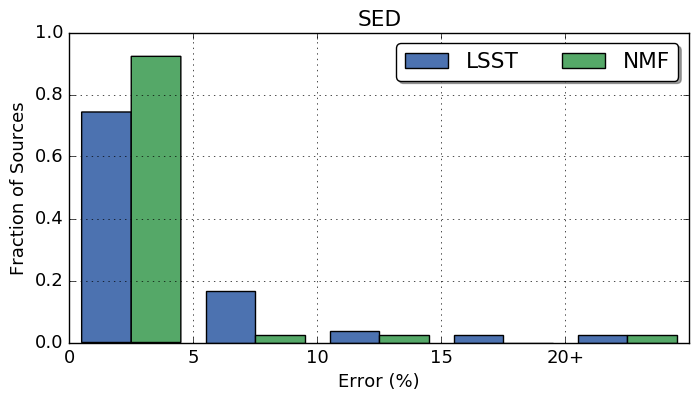

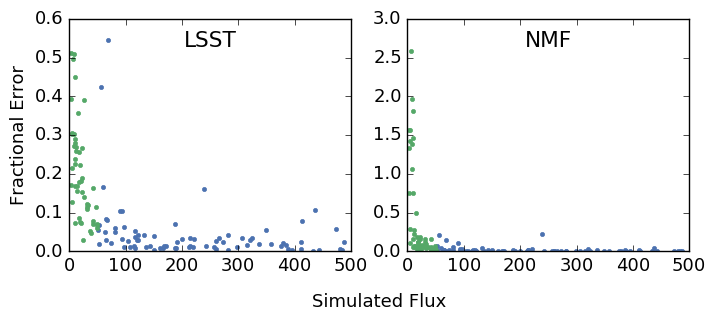

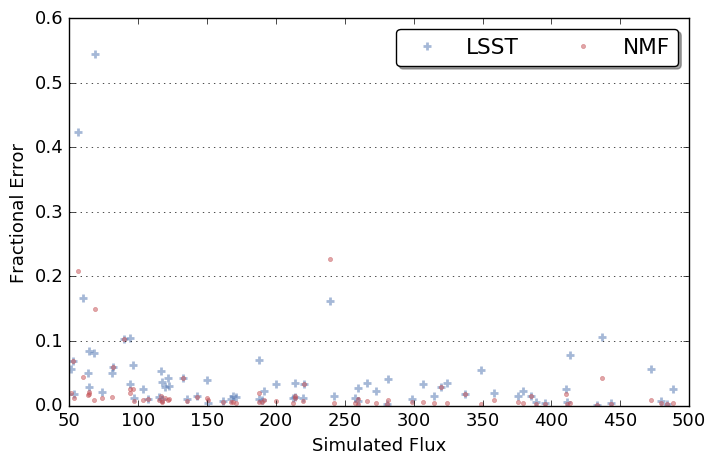

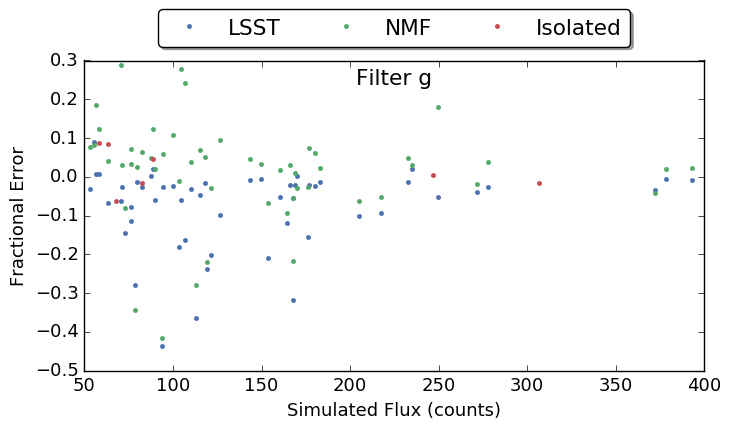

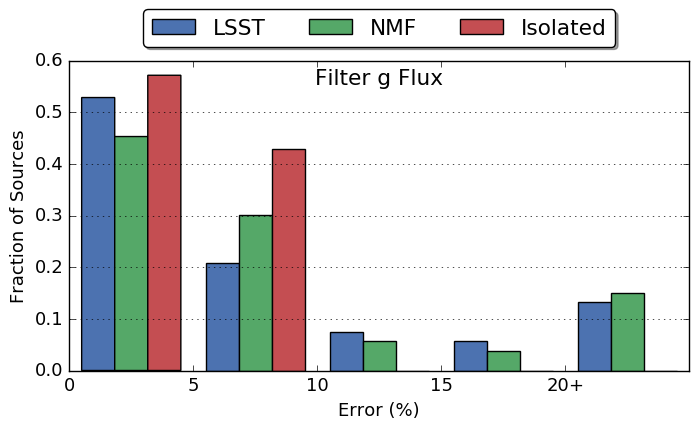

INFO:lsst.meas.deblender:Isolated Mean: 0.045175392936
INFO:lsst.meas.deblender:Isolated RMS: 0.0549009965103
INFO:lsst.meas.deblender:Blended Mean: 0.081821608879
INFO:lsst.meas.deblender:Blended RMS: 0.127212464613


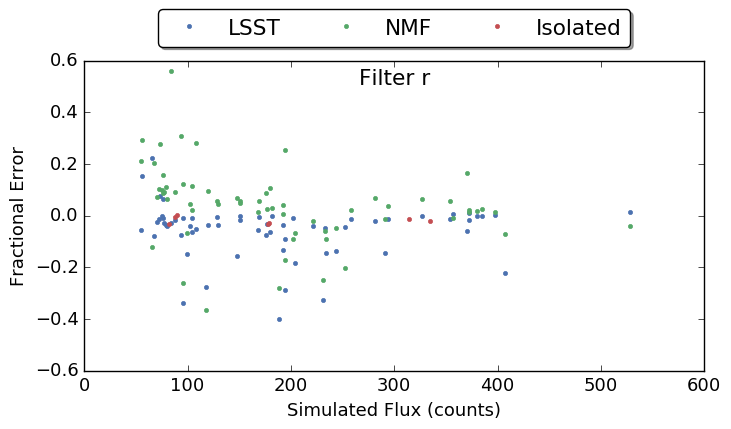

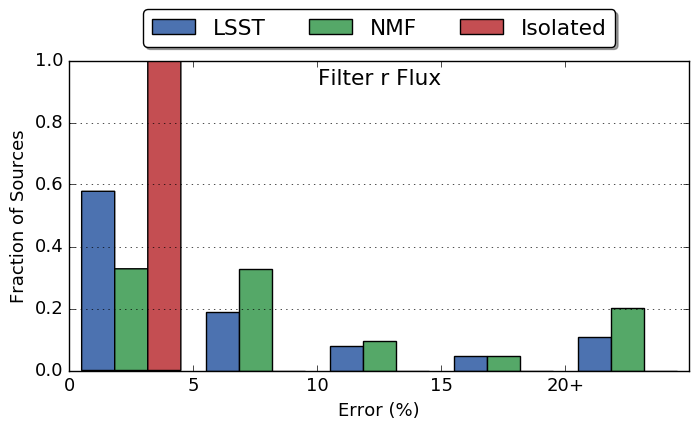

INFO:lsst.meas.deblender:Isolated Mean: 0.0194728002468
INFO:lsst.meas.deblender:Isolated RMS: 0.0231237062062
INFO:lsst.meas.deblender:Blended Mean: 0.0748825448591
INFO:lsst.meas.deblender:Blended RMS: 0.118584010611


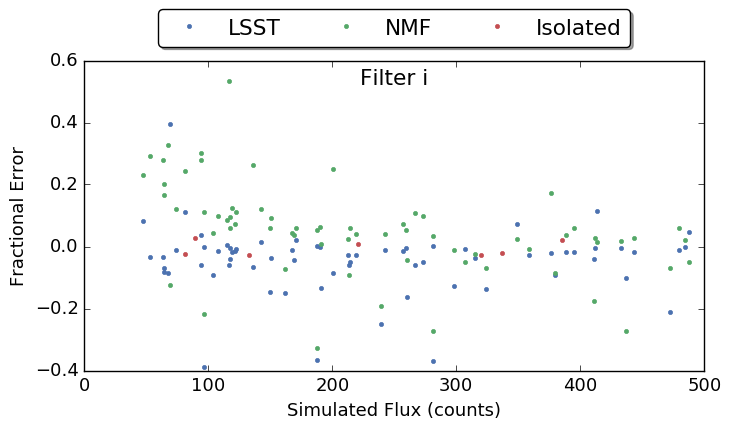

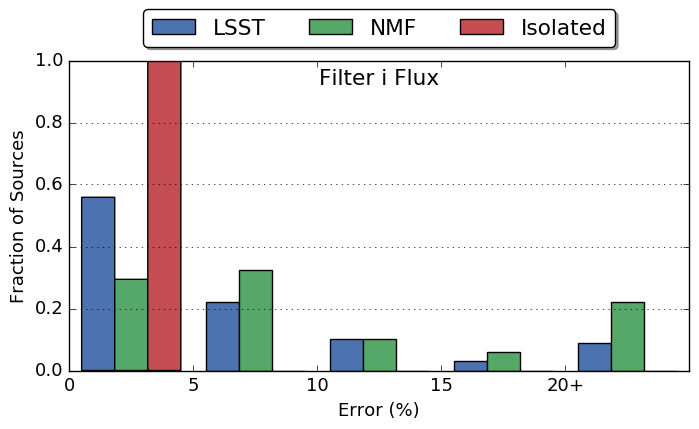

INFO:lsst.meas.deblender:Isolated Mean: 0.0216797277902
INFO:lsst.meas.deblender:Isolated RMS: 0.022661779349
INFO:lsst.meas.deblender:Blended Mean: 0.0724308316464
INFO:lsst.meas.deblender:Blended RMS: 0.117878412774


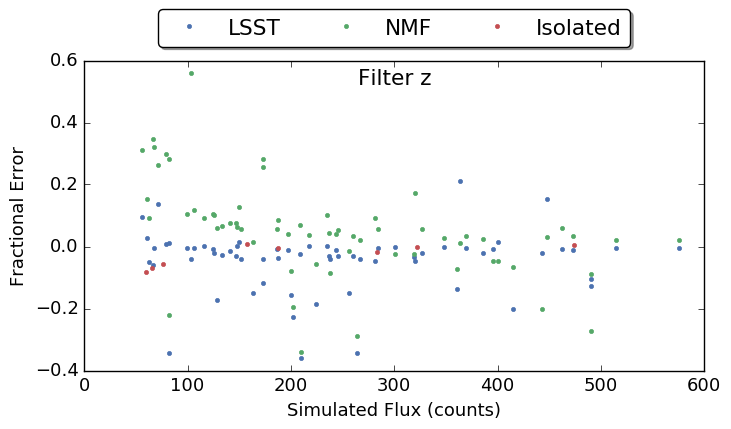

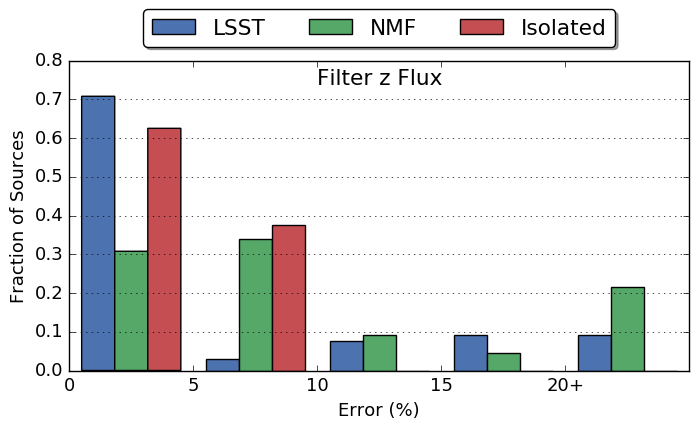

INFO:lsst.meas.deblender:Isolated Mean: 0.0304663563535
INFO:lsst.meas.deblender:Isolated RMS: 0.0438974793924
INFO:lsst.meas.deblender:Blended Mean: 0.0663083045531
INFO:lsst.meas.deblender:Blended RMS: 0.109438420652


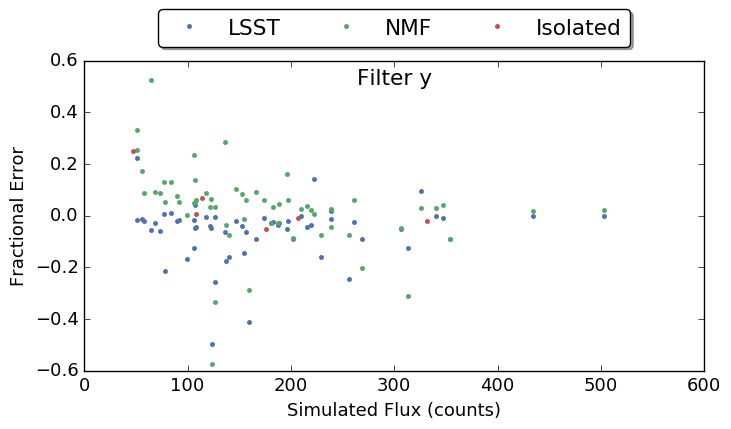

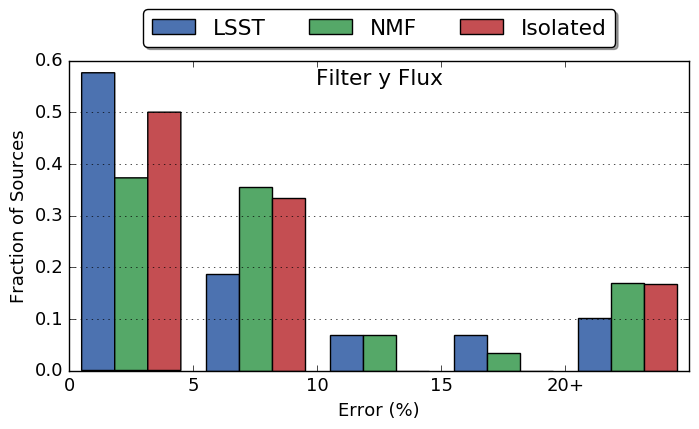

INFO:lsst.meas.deblender:Isolated Mean: 0.0671428715713
INFO:lsst.meas.deblender:Isolated RMS: 0.10774486744
INFO:lsst.meas.deblender:Blended Mean: 0.0783384373076
INFO:lsst.meas.deblender:Blended RMS: 0.124220561683


In [7]:
peakTable, simTable, nmfPeakTable = sim.compareMeasToSim(peakTables, simTables, nmfPeakTables, filters)

In [33]:
parent = expDb.deblendedParents[1]
templates = [parent.getTemplate(0, pk) for pk in range(len(parent.peaks))]
peakCount = len(parent.peaks)
dotFlux = np.zeros((peakCount, peakCount))
degenerateFlux = np.zeros((peakCount, peakCount))
for i in range(peakCount):
    for j in range(i+1):
        dotFlux[i,j] = np.sum(templates[i]*templates[j])

for i in range(peakCount):
    for j in range(i):
        norm = dotFlux[i,i]*dotFlux[j,j]
        if norm<=0:
            degenerateFlux[i,j] = 0
        else:
            degenerateFlux[i,j] /= np.sqrt(norm)

